# The DROP class

This is a basic notebook to show how the DROP (Data Reduction OPerator), for the LRA generation, is built.
Please note that this is a very intensive operation in terms of time and memory. It is recommended to use the command line interface (CLI) - the `drop.py` in `AQUA/src/aqua/cli` for doing any of the following operations.

In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
from aqua import Drop
from aqua.util import ConfigPath, username

/LUMI_TYKKY_m8u3qPb/miniconda/envs/env1/lib/python3.12/site-packages/intake_esm/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


We set up some directory and folders, exploiting of `USER` environment variables. You might want to change the outdir if you want to try this notebook.

In [ ]:
model = 'ERA5'
exp = 'era5'
source = 'daily'
catalog = 'obs'

user = username()
outdir = f'/scratch/b/{user}/test_drop/'


if ConfigPath().get_machine()=='levante':
    outdir = f'/scratch/b/{user}/test_drop'
elif ConfigPath().get_machine()=='lumi':
    outdir = f'/users/{user}/scratch/test_drop'

## A dry run
Initilize the class and retrieve the data. We are asking to go to a grid `r100` at monthly frequency. No data will be produced, we just check that everything is in place! Therefore we use `info` as loglevel to output all we need.

In [9]:
var='tnlwrf'
resolution='r100'
frequency='monthly'
year=2020

test = Drop(catalog=catalog, model=model, exp=exp, source=source, var=var, outdir=outdir,
                     resolution=resolution, frequency=frequency, loglevel='info')
test.retrieve()
test.data = test.data.sel(time=test.data.time.dt.year == year)
test.drop_generator()

2025-10-07 17:59:10 :: DROP :: INFO     -> Frequency: monthly
2025-10-07 17:59:10 :: DROP :: WARNING  -> IMPORTANT: no file will be created, this is a dry run
2025-10-07 17:59:10 :: DROP :: INFO     -> Variable(s) to be processed: tnlwrf
2025-10-07 17:59:10 :: DROP :: INFO     -> Fixing data: True
2025-10-07 17:59:10 :: DROP :: INFO     -> Resolution: r100
2025-10-07 17:59:10 :: DROP :: INFO     -> Statistic to be computed: mean
2025-10-07 17:59:10 :: DROP :: INFO     -> Domain selection: None
2025-10-07 17:59:10 :: DROP :: WARNING  -> No tmpdir specifield, will use outdir
2025-10-07 17:59:10 :: create_folder :: INFO     -> Folder /users/padavini/scratch/test_drop/obs/ERA5/era5/r1/r100/monthly/mean/global already exists
2025-10-07 17:59:10 :: create_folder :: INFO     -> Creating folder /users/padavini/scratch/test_drop/tmp/DROP_oEpWXrLxEG
2025-10-07 17:59:10 :: ConfigPath :: INFO     -> ERA5_era5_daily triplet found in in obs!
2025-10-07 17:59:11 :: Fixer :: INFO     -> Convention dic

# A real run 

Initialize the LRA class, but setting `definitive` as true to create the actual data. Frequency is `daily` in this case.

In [10]:
frequency='daily'

test_run = Drop(catalog=catalog, model=model, exp=exp, source=source, var=var, outdir=outdir,
                    resolution=resolution, frequency=frequency, definitive=True)

2025-10-07 17:59:28 :: DROP :: WARNING  -> No tmpdir specifield, will use outdir


Retrieve the required data: they are stored in the `data` object.

In [11]:
test_run.retrieve()
test_run.data

<xarray.Dataset> Size: 126GB
Dimensions:  (time: 30316, lon: 1440, lat: 721)
Coordinates:
  * time     (time) datetime64[ns] 243kB 1940-01-01T15:00:00 ... 2022-12-31T1...
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
Data variables:
    tnlwrf   (time, lat, lon) float32 126GB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Sat Nov 18 14:40:07 2023: cdo -O -s -f nc4 -z zip -daymean ...
    frequency:    day
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

Since this is a very intenstive operation, we do a hack and subselect the first month of the first year. The LRA loops on monthly data so that it can operate in a faster and less memory intensive way. We might want to move to OPA in the future, but so far simple `timmean` call are used

In [12]:
year=2020
month=1

data_per_year = test_run.data.sel(time=test_run.data.time.dt.year == year)
data_per_month = data_per_year.sel(time=data_per_year.time.dt.month == month)
test_run.data = data_per_month

Real run of the LRA, a couple of minutes to produce a monthly data for tprate

In [13]:
test_run.drop_generator()

[########################################] | 100% Completed | 7.95 ss


There is also an option to create an entry in the catalog (`.create_catalog_entry()`), but to avoid complication and to mess up with the original catalog this is not used here. To inspect the output produced, we just use xarray:

In [18]:
import os
import xarray as xr
formatted_month = f"{month:02d}"
filename = f"{var}_{catalog}_{model}_{exp}_r1_{resolution}_{frequency}_mean_global_{year}{formatted_month}.nc"
path = os.path.join(outdir, catalog, model, exp, 'r1', resolution, frequency, 'mean', 'global', filename)
file = xr.open_dataset(path)
file

<xarray.Dataset> Size: 16MB
Dimensions:  (time: 31, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 248B 2020-01-01 2020-01-02 ... 2020-01-31
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    tnlwrf   (time, lat, lon) float64 16MB ...

From this file we can plot, for example, daily values of precipitation:

/LUMI_TYKKY_m8u3qPb/miniconda/envs/env1/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


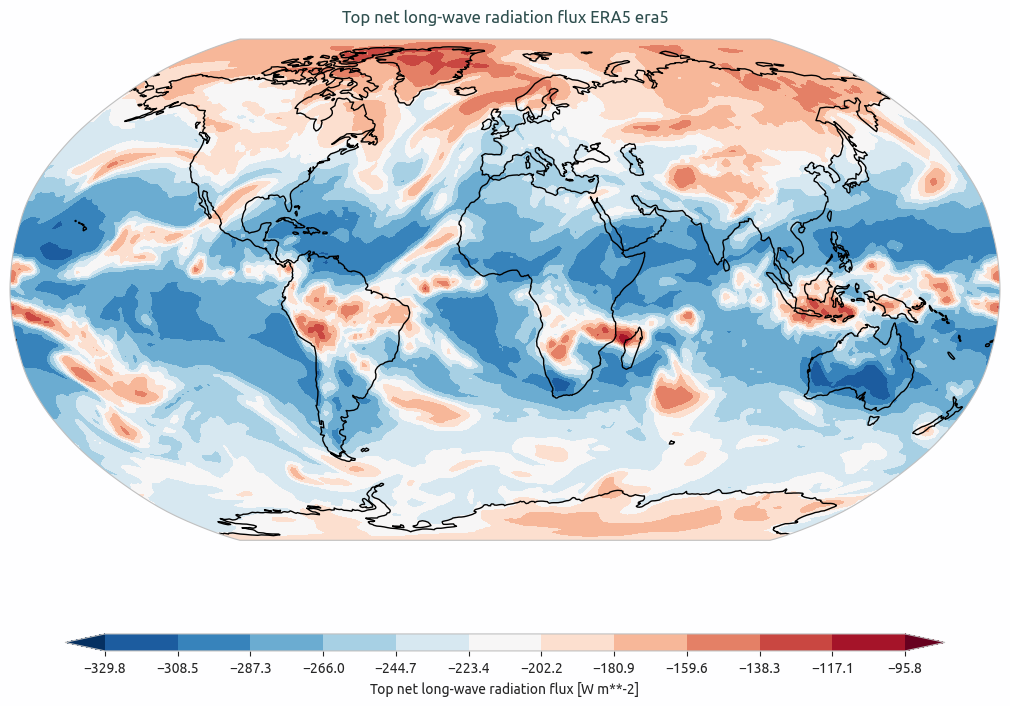

In [19]:
file[var].isel(time=0).aqua.plot_single_map()